# Load libs

In [1]:
import pandas as pd
import numpy as np

from typing import List, Set

from matplotlib import pyplot as plt
import itertools

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


from sklearn.cluster import KMeans

import gensim

from data_cleaning import DataCleaner
from plotly_utils import build_2d_figure, build_3d_figure

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load dataset

In [2]:
df = pd.read_csv("dataset_huge.csv", usecols=["id", "title", "search_query", "description"]).dropna()

# Data analysis
## Query distribution

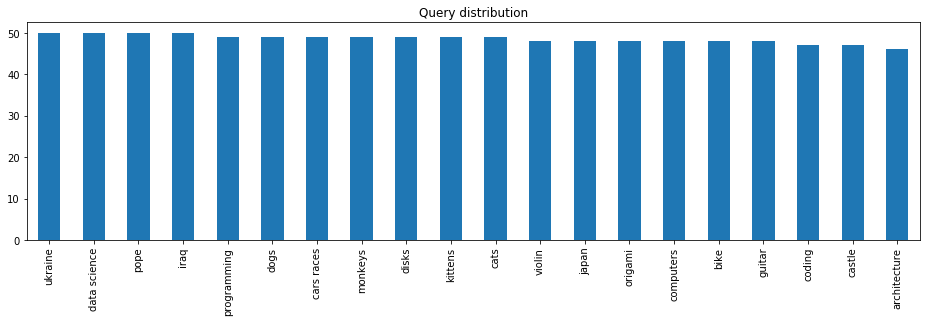

In [3]:
df["search_query"].value_counts().plot(kind="bar", title='Query distribution', figsize=(16, 4))

## Words number in description distribution

Text(0, 0.5, 'Descriptions number with words amount')

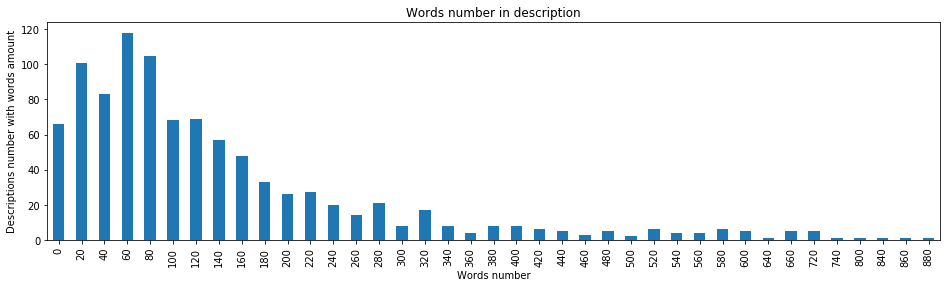

In [4]:
df["description"].apply(
    lambda words: int(len(words.split()) / 20) * 20
).value_counts().sort_index().plot(kind="bar", figsize=(16, 4))

plt.title('Words number in description')
plt.xlabel('Words number')
plt.ylabel('Descriptions number with words amount')

## Dictionary analysis
### Raw dictionary

In [5]:
def build_dictionary(data: pd.Series) -> Set[str]:
    return np.unique(pd.Series(itertools.chain.from_iterable(data.str.split())))

In [6]:
print("Raw dictionary size: {} unique words.".format(len(build_dictionary(df["description"]))))

Raw dictionary size: 32603 unique words.


### Cleaning descriptions

In [7]:
cleaner = DataCleaner()
df["cleaned_description"] = df["description"].apply(cleaner.clean_description)

[nltk_data] Downloading package wordnet to /home/fisz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
print("Cleaned dictionary size: {} unique words.".format(len(build_dictionary(df["cleaned_description"]))))

Cleaned dictionary size: 16269 unique words.


# Embedding
## BOW

In [9]:
# word_vectorizer_fasttext = gensim.models.FastText(
#     size=100, 
#     window=10, 
#     min_count=3, 
#     sentences=df["cleaned_description"], 
#     iter=30
# )
# print("Vocab size: {}".format(len(word_vectorizer_fasttext.wv.vocab)))

# word_vectorizer_word2vec = gensim.models.Word2Vec(
#         df["cleaned_description"],
#         size=100,
#         window=10,
#         min_count=3,
#         workers=10,
#         iter=30,
#         seed=37
# )
# print("Vocab size: {}".format(len(word_vectorizer_word2vec.wv.vocab)))

In [9]:
def vectorize_text(words: List[str], word_vectorizer) -> np.array:
    vectors = []
    for word in words:
        if word in word_vectorizer.wv:
            vectors.append(word_vectorizer.wv[word])
    
    if not vectors: 
        return np.zeros(word_vectorizer_fasttext.wv.vector_size)
    else:
        return np.array(np.mean(vectors, axis=0))

In [10]:
class Doc2VecVectorizer:
    def __init__(self, vector_size: int = 300):
        self.vector_size = vector_size

    def fit_transform(self, texts: List[str]):
        documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(texts)]
        model = Doc2Vec(documents, vector_size=self.vector_size, window=4, min_count=2, workers=4)
        return np.array([model.docvecs[i] for i in range(len(texts))])

In [11]:
# vectorizer = HashingVectorizer(ngram_range=(1, 1), n_features=1000)
# vectorizer = CountVectorizer(ngram_range=(1, 3))
# vectorizer = TfidfVectorizer(ngram_range=(1, 3))
vectorizer = Doc2VecVectorizer(vector_size=100)

dimension_reductor = TruncatedSVD(n_components=3) 
# dimension_reductor = PCA(n_components=3)
# dimension_reductor = KernelPCA(n_components=3)

descriptions = df["cleaned_description"]

embeddings = vectorizer.fit_transform(descriptions)
truncated_embeddings = dimension_reductor.fit_transform(embeddings)

encoded_labels = LabelEncoder().fit_transform(df["search_query"])

2020-01-14 19:25:40,797 : INFO : collecting all words and their counts
2020-01-14 19:25:40,798 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-01-14 19:25:40,839 : INFO : collected 16269 word types and 971 unique tags from a corpus of 971 examples and 132122 words
2020-01-14 19:25:40,840 : INFO : Loading a fresh vocabulary
2020-01-14 19:25:40,938 : INFO : effective_min_count=2 retains 7538 unique words (46% of original 16269, drops 8731)
2020-01-14 19:25:40,938 : INFO : effective_min_count=2 leaves 123391 word corpus (93% of original 132122, drops 8731)
2020-01-14 19:25:40,977 : INFO : deleting the raw counts dictionary of 16269 items
2020-01-14 19:25:40,977 : INFO : sample=0.001 downsamples 48 most-common words
2020-01-14 19:25:40,978 : INFO : downsampling leaves estimated 100812 word corpus (81.7% of prior 123391)
2020-01-14 19:25:41,006 : INFO : estimated required memory for 7538 words and 100 dimensions: 10187800 bytes
2020-01-14 19:25:41,007 : 

In [13]:
predicted_classes = KMeans(n_clusters=20).fit_predict(embeddings)

In [15]:
fig = build_2d_figure(df, predicted_classes, truncated_embeddings)
fig.show()